<a href="https://colab.research.google.com/github/h0806449f/Pytorch/blob/main/02_neural_network_clf_fromYTvideo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make classification data and get it ready

In [78]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
            noise=0.03,
            # random seeds
            random_state=42)


In [79]:
X.shape, y.shape

((1000, 2), (1000,))

In [80]:
print("First 5 samples of X:\n", X[:5])
print("First 5 samples of y:\n", y[:5])

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [81]:
# DF of circle data
import pandas as pd

circles = pd.DataFrame( {"X1" : X[:,0],
               "X2" : X[:,1],
               "label" : y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


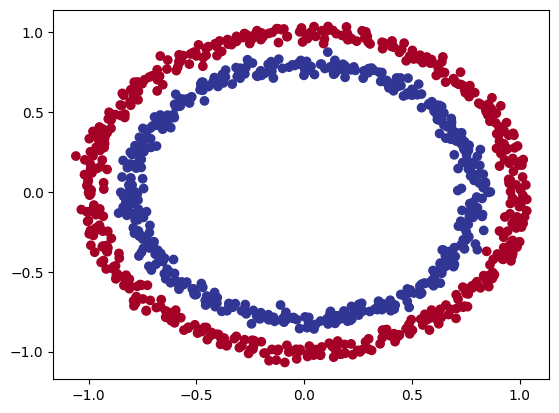

In [82]:
# Visualize
import matplotlib.pyplot as plt

plt.scatter( x=X[:, 0],
        y=X[:, 1],
        c=y,
        cmap=plt.cm.RdYlBu )

# 1.1 Check data shape

In [83]:
X.shape, y.shape

((1000, 2), (1000,))

In [84]:
# check 
X[0], y[0]

(array([0.75424625, 0.23148074]), 1)

# 1.2 Trun data into tensor and create train, test splits

In [85]:
# Turn data into torch
import torch

X.dtype   # dtype('float64')

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X, X.dtype, y.dtype

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         ...,
         [-0.1369, -0.8100],
         [ 0.6704, -0.7675],
         [ 0.2811,  0.9638]]),
 torch.float32,
 torch.float32)

In [86]:
# Split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                              y,
                              test_size=0.2,
                              random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# Build model  

1. Setup device
2. Construct model (by subclassing nn.module)
3. Define loss function and optimizer
4. Create training and testing loop

In [87]:
# Import Pytorch and nn
import torch
from torch import nn

# Setup device
device = "cuda" if torch.cuda.is_available() else "cpu"
device 

'cpu'

In [88]:
# Create model
# 1. Subclass "nn.Module" (almost all models in Pytorch subclass "nn.Moudle")
# 2. Create 2 "nn.Linear()" layers (since our data got 2 classes)
# 3. Define "forward()"
# 4. Instatiate an instance of our model class and send it to the target device
# 將模型放置在運算設備上。PyTorch可以偵測運算設備，並根據該設備進行優化，例如使用GPU進行計算。

In [89]:
# 1. Subclass nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()

        # 2. Create 2 nn.Linear (process the data)
        self.layer_1 = nn.Linear(in_features=2, out_features=8) # 2 -> upscales to 5 features
        self.layer_2 = nn.Linear(in_features=8, out_features=1)
    
    # 3. Define forward()
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4. Instatiate an instance
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

In [90]:
# 使用 nn.Sequential() 複製上面的模型
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.Linear(in_features=8, out_features=1)
).to(device)

model_1

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)

In [91]:
# 額外 : Make prediction
untrained_preds = model_1(X_test.to(device))

print("Length of prediction: ", len(untrained_preds))
print("Shape of prediction: ", untrained_preds.shape)

print("\nLength of test: ", len(X_test))
print("Shape of test: ", X_test.shape)

print("\nFirst 10 prediction", torch.round(untrained_preds[:10]))   # torch.round # 目前模型全部預測0
print("\nFirst 10 labels", y_test[:10])

Length of prediction:  200
Shape of prediction:  torch.Size([200, 1])

Length of test:  200
Shape of test:  torch.Size([200, 2])

First 10 prediction tensor([[-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.],
        [-0.]], grad_fn=<RoundBackward0>)

First 10 labels tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


# 2.1 Choose loss function and optimizer
1. For regression : usually MAE or MSE
2. For classification : usually binary cross entropy or categorical cross entropy
  
  
3. Optimizer : usually Adam or SGD 
4. More info : https://www.learnpytorch.io/02_pytorch_classification/

In [92]:
# Setup loss function
# 這邊的問題是 binary 
loss_fn = nn.BCEWithLogitsLoss()   # sigmoid function build-in

optimizer = torch.optim.SGD(params=model_1.parameters(),
                lr=0.1)

In [93]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

# Train model
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. backward pass (Loss backward)
5. Optimizer (gradient descent)

# 3.1 Raw logits -> prediction probabilities -> prediction labels
logits 是指"未經過" softmax 函數處理的輸出值  
通常用於多類別分類任務的最後一層輸出，並且會作為損失函數的輸入。

In [94]:
# View the first 5 outputs of the forward pass on the test data

# 轉換為 evaluate 模式
model_1.eval()

# 只是檢視最後預測值 所以關閉梯度計算
with torch.no_grad():
    y_logits = model_0(X_test.to(device))[:5]

# 比較 logits and y_test
y_logits, y_test[:5]

(tensor([[-0.3104],
         [-0.4788],
         [ 0.1177],
         [-0.4316],
         [ 0.0967]]),
 tensor([1., 0., 1., 0., 1.]))

In [95]:
# 使用 sigmoid 激活 logits
# y_pred_probs < 0.5 將被歸類到 class 0 y=0
# y_pred_probs >= 0.5 將被歸類到 class 1 y=1

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

# sigmoid 激活後 -> round
y_pred = torch.round(y_pred_probs)

In [96]:
# prediction labels # 將 cell 21 - 22 一次做完
# 使用 sigmoid 將 logits 轉為機率
# 使用 round 將機率 轉換為 0 or 1 labels
y_pred_labels = torch.round(torch.sigmoid(model_1(X_test.to(device))[:5]))
y_pred_labels

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<RoundBackward0>)

In [97]:
# 檢查 預測值 與 test 是否一樣

y_pred_labels.squeeze(), y_test[:5]

(tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>),
 tensor([1., 0., 1., 0., 1.]))

# 3.2 Build training and testing loop

In [98]:
torch.manual_seed(42)   # torch.cuda.manual_seed(42) 也可以

# set number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluate loop
for epoch in range(epochs):
    # Training !!!
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    # 1.1 turn logits into probilities and then trun into labels
    y_pred = torch.round(torch.sigmoid(y_logits)) 

    # 2. Calculate loss/accuracy
    # Loss function : nn.BCEWithLogitsLoss 需使用 logits 為input
    # Compare with y_train
    loss = loss_fn(y_logits,
             y_train)
    acc = accuracy_fn(y_true = y_train,
               y_pred = y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Test !!!
    model_1.eval()
    with torch.no_grad():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate loss/acc
        # Loss function : nn.BCEWithLogitsLoss 需使用 logits 為input
        # Compare with y_test
        test_loss = loss_fn(test_logits,
                    y_test)
        test_acc = accuracy_fn(y_true = y_test,
                     y_pred = test_pred)
        
        # 3. Print out the process
        if epoch % 10 == 0:
            print(f"Epoch: {epoch}")
            print(f"Loss: {loss:.4f}, Acc:{acc:.2f}%")
            print(f"Test loss: {test_loss:.4f}, Test acc:{test_acc:.2f}%")
            print("=" * 50)

Epoch: 0
Loss: 0.7081, Acc:50.00%
Test loss: 0.7073, Test acc:50.00%
Epoch: 10
Loss: 0.6967, Acc:50.00%
Test loss: 0.6975, Test acc:50.00%
Epoch: 20
Loss: 0.6939, Acc:45.88%
Test loss: 0.6952, Test acc:42.00%
Epoch: 30
Loss: 0.6933, Acc:46.88%
Test loss: 0.6947, Test acc:49.00%
Epoch: 40
Loss: 0.6931, Acc:49.25%
Test loss: 0.6946, Test acc:49.00%
Epoch: 50
Loss: 0.6931, Acc:50.00%
Test loss: 0.6945, Test acc:48.50%
Epoch: 60
Loss: 0.6930, Acc:50.50%
Test loss: 0.6945, Test acc:47.50%
Epoch: 70
Loss: 0.6930, Acc:50.75%
Test loss: 0.6945, Test acc:47.50%
Epoch: 80
Loss: 0.6930, Acc:50.38%
Test loss: 0.6945, Test acc:48.00%
Epoch: 90
Loss: 0.6930, Acc:51.12%
Test loss: 0.6945, Test acc:48.00%


# Evaluate the model
經過100次訓練後 loss沒有顯著下降  
重新檢查

In [ ]:
import requests
from pathlib import Path

# Download help functions from ....
if Path("helper_function.py").is_file():
    print("helper_function.py already exists, skip download")
else:
    print("Downloading")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_function.py", "wb") as f:
        f.write(request.content)

from helper_function import plot_predictions, plot_decision_boundary

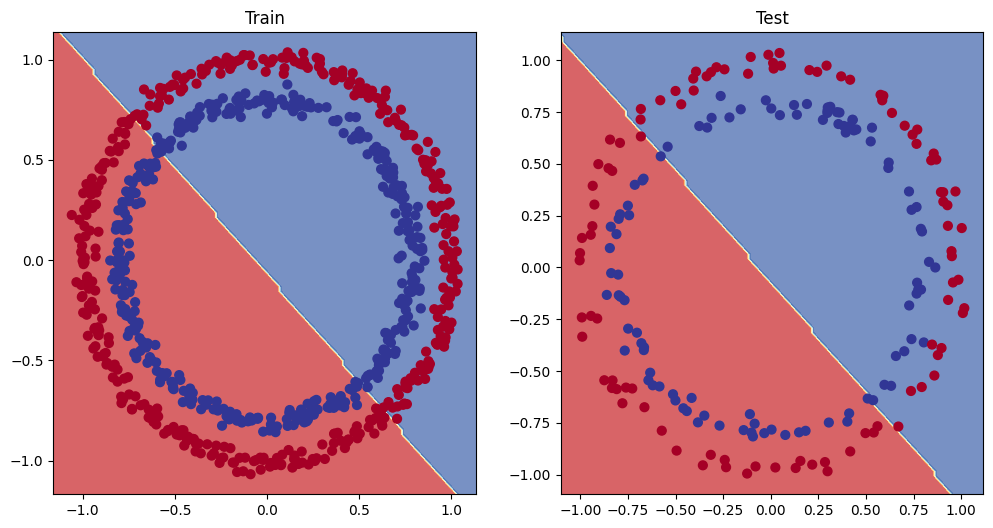

In [104]:
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [ ]:
# 模型效果不好的原因
# 資料分佈是圓形的   但我們的模型試圖使用 linear regression 去分析資料
# 可能需要使用其他分析途徑